# Model Agricultural Soil Moisture

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp

data_dir='/fd1/QibinShi_data/England_farm/'
matplotlib.rcParams.update({'font.size': 16})

## Data: Relative humidity, rainfall, temperature and the velocity change

Text(0, 0.5, 'temperature at 10cm (C)')

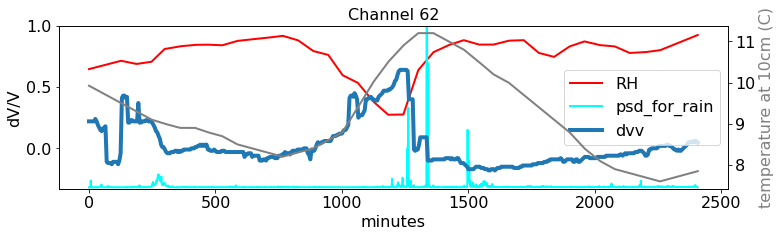

In [2]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    psd = f['psd_rain'][:]
    temp = f['temperature'][:]

s=moisture/100*2-1
    
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), s, label='RH', color='r', lw=2)
plt.plot(np.arange(len(psd)), psd * 5-0.32, label='psd_for_rain', color='cyan', lw=2)
plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
plt.ylim(-0.33, 1)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("dV/V", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()
twinx = plt.twinx()
twinx.plot(np.arange(2408), temp, color='gray', lw=2, label='temperature')

twinx.set_ylabel("temperature at 10cm (C)", fontsize=16, color='gray')

## Hydrological models

### The evaporation slope

During the evaporation period, the water balance is mainly sensitive to the solar radiation and temperature.

This simple model gives bounds for the evaporation coefficient. 

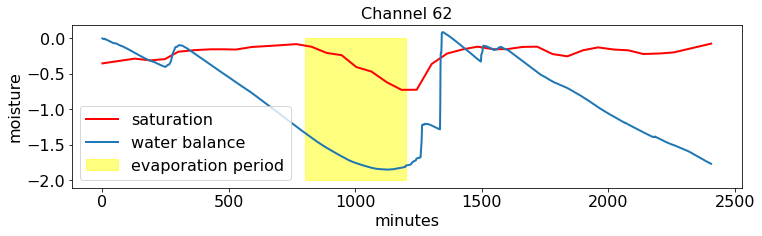

In [21]:
## This model assumes a uniform moisture at the surface and the depth
## The moisture is from the measured RH data
class hydro:
    def __init__(self, prec, porosity, s, T, I, till, tire, A_p, A_e, A_d):
        self.prec = prec
        self.s = (s-0.28)/0.62
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d

        ## evaporation
        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239
        self.pet = 1.6 * np.power((10*self.T / self.I), self.a)
        self.evap = self.pet * self.s * self.till * self.tire   ## Evaporation rate

        ## drainage
        self.drain = self.prec * self.s * self.till * self.tire  ## Drainage rate

    def get_s_rate(self):
        prec_rate = self.A_p * self.prec
        evap_rate = self.A_e * self.evap
        drain_rate = self.A_d * self.drain
        s_rate = prec_rate - evap_rate - drain_rate

        return s_rate, prec_rate, evap_rate, drain_rate, self.pet

s_rate, prec_rate, evap_rate, drain_rate, pet = hydro(np.roll(psd, 1), 0.5, s, temp, 12, 25, 7, 0.9,0.000003,0.0000005).get_s_rate()

plt.figure(figsize=(12, 3))
plt.fill_between([800,1200], [-2,-2], [0,0], color='yellow', alpha=0.5, label='evaporation period')
plt.plot(np.arange(2408), s-1, label='saturation', color='r', lw=2)
plt.plot(np.arange(2408), np.cumsum(s_rate), label='water balance', lw=2)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

### The precipitation slope

During the precipitation period, the water balance is mainly controlled by precipitation and drainage.

This simple model test the relation between the drainage and the instant level of water saturation. 

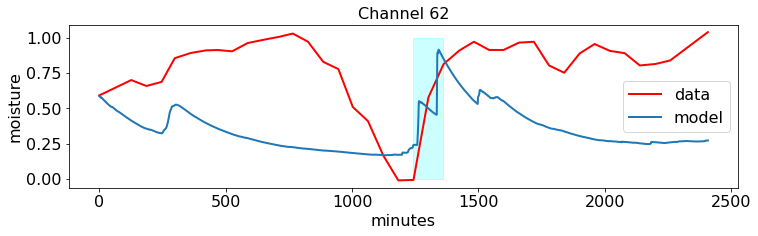

In [23]:
## This model assumes a uniform moisture at the surface and the depth
## The moisture is from the forward modelled water saturation
class hydro0:
    def __init__(self, prec, porosity, s0, T, I, till, tire, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.pet * self.s * self.till * self.tire   ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.till * self.tire  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain
            s_rate = prec_rate - evap_rate - drain_rate
            self.s += s_rate
            s_history[i] = self.s

        return s_history
    
s_history = hydro0(np.roll(psd, 1), 0.5, (s[0]-0.28)/0.62, temp, 12, 25, 7, 1,0.000003,0.0057).get_s_history()

plt.figure(figsize=(12, 3))
plt.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
plt.plot(np.arange(2408), (s-0.28)/0.62, label='data', color='r', lw=2)
plt.plot(np.arange(2408), s_history, label='model', lw=2)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()
        

## The time dependent factors: radiation, temperature, rainfall and wind

In [4]:
## This model use surface moisture and actual weather data to account for the evaporation
## The moisture at depth is forward modelled to account for the drainage
## The PSD data is calibrated to model the water increase due to the rain
class hydro0_sur_piecewise:
    def __init__(self, prec, porosity, s0, s_sur, T, I, radiation, till, tire, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.s_sur = s_sur
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.radiation = radiation
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.pet * self.s_sur[i] * self.till * self.tire * self.radiation[i]  ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.till * self.tire  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain
            s_rate = prec_rate - evap_rate - drain_rate
            self.s += s_rate
            s_history[i] = self.s

        return s_history

#### Weather data

In [3]:
csv_file = pd.read_csv('met_newport.csv')
air_temp = csv_file['Temperature'].to_numpy()
wind_speed = csv_file['Wind Speed'].to_numpy()*1000/3600
wind_speed_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(wind_speed) * 30, 30), wind_speed)

#### PSD and the time stamp

2023-03-17T18:00:00.000000Z
2023-03-18T00:00:00.000000Z
2023-03-18T06:00:00.000000Z
2023-03-18T12:00:00.000000Z
2023-03-18T18:00:00.000000Z
2023-03-19T00:00:00.000000Z
2023-03-19T06:00:00.000000Z


Text(1443, 0.8, 'sunset')

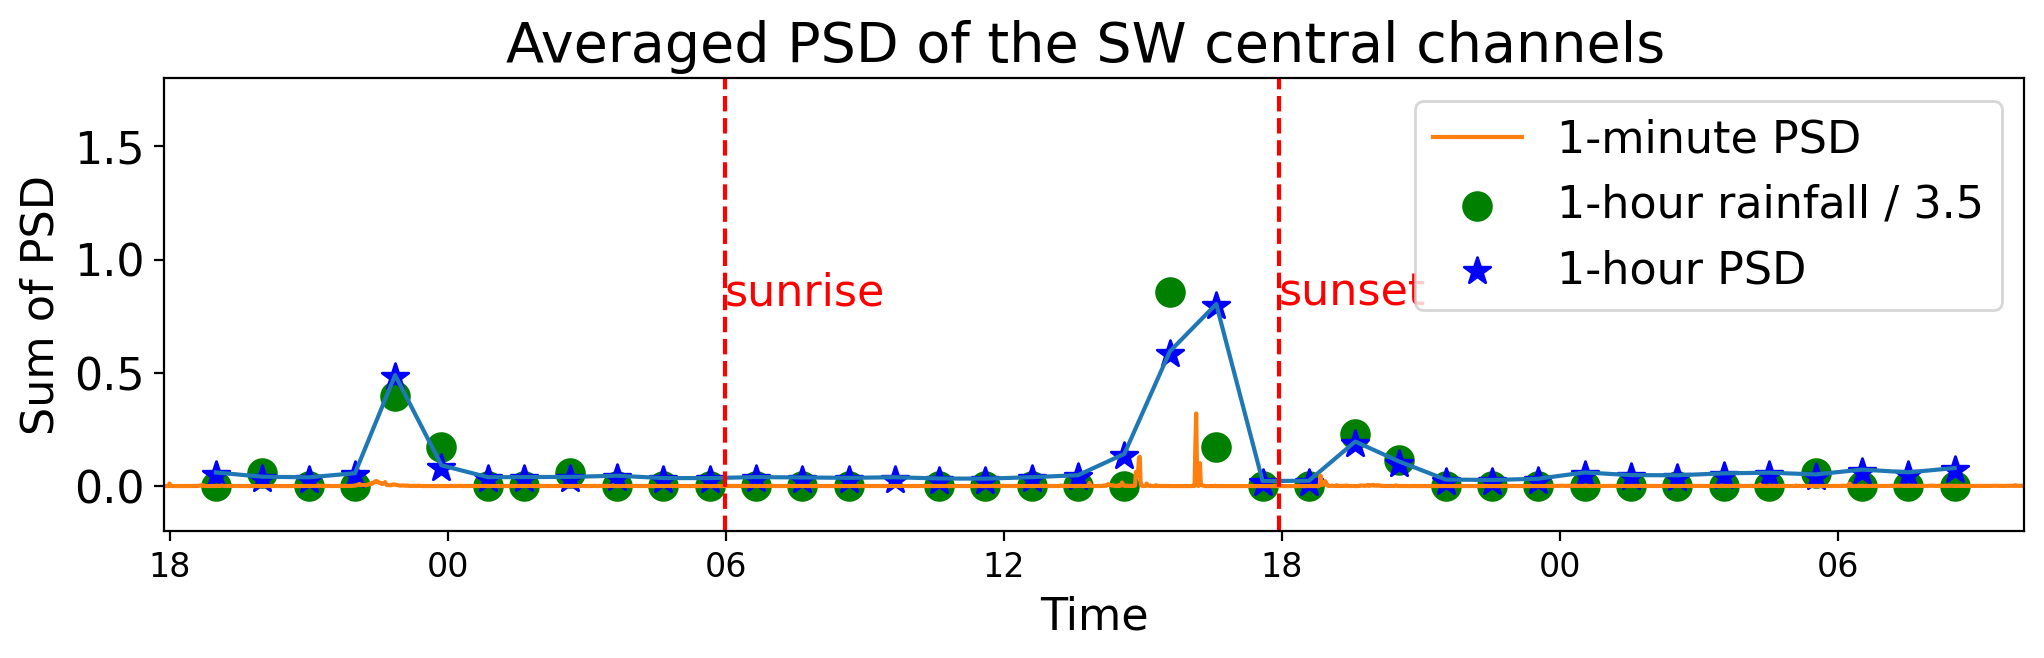

In [9]:
csv_file = pd.read_csv('NewportSalop_merged.csv', low_memory=False).dropna(axis='columns', how='all')
## Index for soil measurements
j = 32
# print(csv_file['Time'][j:j+40])

humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall=csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)

air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()

with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
    PSD_all_time = f['psd_all_time'][:]
    freq = f['frequency'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list])
start_file = np.arange(0, len(acqu_time), 5)
time_stamps = acqu_time[start_file]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0)
for i in range(len(ave_psd)):
    if i >1300 and i < 1800:
        ave_psd[i] = ave_psd[i] / 2

## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## smoothing over 1 hr window
hr_psd=[]
for ind in hourly_index:
    st_ind = int(ind - 60)
    ed_ind = st_ind + 60

    hr_psd.append(np.sum(ave_psd[st_ind:ed_ind]))

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]
for i in Ind6hrs:
    print(acqu_time[i])

xax=np.arange(7, psd.shape[-1], 360)
tax=acqu_time[7:psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]
plt.figure(figsize = (12, 3), dpi = 200)   
plt.scatter(hourly_index, rain_diff/3.5, label='1-hour rainfall / 3.5', color='g', marker='o', s=100)
plt.scatter(hourly_index, np.array(hr_psd)-0.01, label='1-hour PSD', color='b', marker='*', s=100)
plt.plot(hourly_index, np.array(hr_psd))
plt.plot(np.arange(psd.shape[-1]), ave_psd, label='1-minute PSD')
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Sum of PSD", fontsize = 16)
plt.title('Averaged PSD of the SW central channels ', fontsize = 20)  
plt.ylim(-0.2, 1.8)
plt.xlim(0, ave_psd.shape[-1])
plt.legend()

plt.axvline(x = 726, color = 'red', linestyle='--')
plt.axvline(x = 1443, color = 'red', linestyle='--')
plt.text(726, 0.8, 'sunrise', color='r')
plt.text(1443, 0.8, 'sunset', color='r')

### Combining the above factors

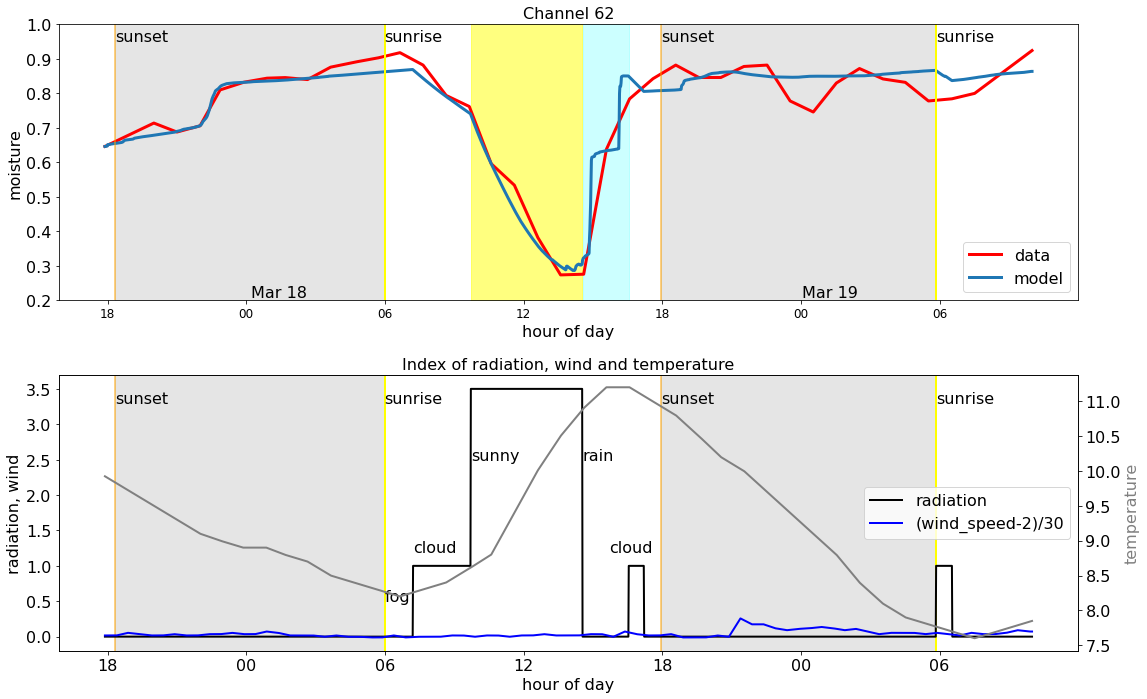

In [22]:
A_e = 0.000001
rad = np.zeros(2408)
rad[800:950] = 1
rad[950:1240] = 3.5
rad[1360:1400] = 1
rad[2158:2200] = 1


A_d = 0.0057
A_p = 1.0

### calibrate the psd data
ave_psd = np.zeros_like(psd)
for i in range(len(psd)):
    if i >1300 and i < 1800:
        ave_psd[i] = psd[i] / 2
    else:
        ave_psd[i] = psd[i]

s_history = hydro0_sur_piecewise(ave_psd, 0.5, s[0], s, temp, 9, rad+(wind_speed_interpolated-2)/30, 25, 7, A_p,A_e,A_d).get_s_history()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Model the water balance
ax1.fill_between(np.arange(2408), 0, 1, where=rad > 1, color='yellow', alpha=0.5)
ax1.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
ax1.fill_between([27,726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.plot(np.arange(2408), s, label='data', color='r', lw=3)
ax1.plot(np.arange(2408), s_history, label='model', lw=3)
ax1.set_ylim(0.2, 1)
ax1.set_xlabel("hour of day", fontsize=16)
ax1.set_ylabel("moisture", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.set_title("Channel 62", fontsize=16)
ax1.legend()
ax1.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.text(27, 0.95, 'sunset', color='k')
ax1.text(726, 0.95, 'sunrise', color='k')
ax1.text(1443, 0.95, 'sunset', color='k')
ax1.text(2158, 0.95, 'sunrise', color='k')
ax1.text(Ind6hrs[1] + 20, 0.21, 'Mar 18', color='k')
ax1.text(Ind6hrs[5] + 30, 0.21, 'Mar 19', color='k')

# Weather data
ax2.fill_between([27,726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax2.set_ylim(-0.2, 3.7)
ax2.text(726, 0.5, 'fog', color='k')
ax2.text(800, 1.2, 'cloud', color='k')
ax2.text(950, 2.5, 'sunny', color='k')
ax2.text(1240, 2.5, 'rain', color='k')
ax2.text(1310, 1.2, 'cloud', color='k')
ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.text(27, 3.3, 'sunset', color='k')
ax2.text(726, 3.3, 'sunrise', color='k')
ax2.text(1443, 3.3, 'sunset', color='k')
ax2.text(2158, 3.3, 'sunrise', color='k')
ax2.plot(np.arange(2408), rad, color='k', lw=2, label='radiation')
ax2.plot(np.arange(2408), (wind_speed_interpolated-2)/30, color='b', lw=2, label='(wind_speed-2)/30')
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=16)
ax2.set_xlabel("hour of day", fontsize=16)
ax2.set_ylabel("radiation, wind", fontsize=16)
ax2.set_title("Index of radiation, wind and temperature", fontsize=16)
ax2.legend(loc='center right')

twinx = ax2.twinx()
twinx.plot(np.arange(2408), temp, color='gray', lw=2, label='temperature')
twinx.set_ylabel("temperature", fontsize=16, color='gray')

plt.tight_layout()
plt.show()
